# Capstone Notebook

# Stakeholder and Business Problem

This project is intended to provide the Minnesota Department of Transportation (MNDOT) with information and recommendations about what factors lead to heavy traffic volume and if anything can be done along I-94 to mitigate these factors. The dataset was pulled from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#).

In [247]:
# Import tools and libraries
import pandas as pd
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1)

# try:
    # %load_ext autotime
# except:
    # !pip install ipython-autotime
    # %load_ext autotime
    
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2023-04-05 17:52:35 -06:00)


In [248]:
# Read in traffic data
df = pd.read_csv('data\Metro_Interstate_Traffic_Volume.csv')
df_noaa = pd.read_csv('data/noaa_data.csv')

time: 110 ms (started: 2023-04-05 17:52:35 -06:00)


In [249]:
# Previewing data
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


time: 15 ms (started: 2023-04-05 17:52:35 -06:00)


Per the UCI website that hosts the data, the feature descriptions are as follows:

holiday: Categorical US National holidays plus regional holiday, Minnesota State Fair<br>
temp: Numeric Average temp in kelvin<br>
rain_1h: Numeric Amount in mm of rain that occurred in the hour<br>
snow_1h: Numeric Amount in mm of snow that occurred in the hour<br>
clouds_all: Numeric Percentage of cloud cover<br>
weather_main: Categorical Short textual description of the current weather<br>
weather_description: Categorical Longer textual description of the current weather<br>
date_time: DateTime Hour of the data collected in local CST time<br>
traffic_volume: Numeric Hourly I-94 ATR 301 reported westbound traffic volume<br>

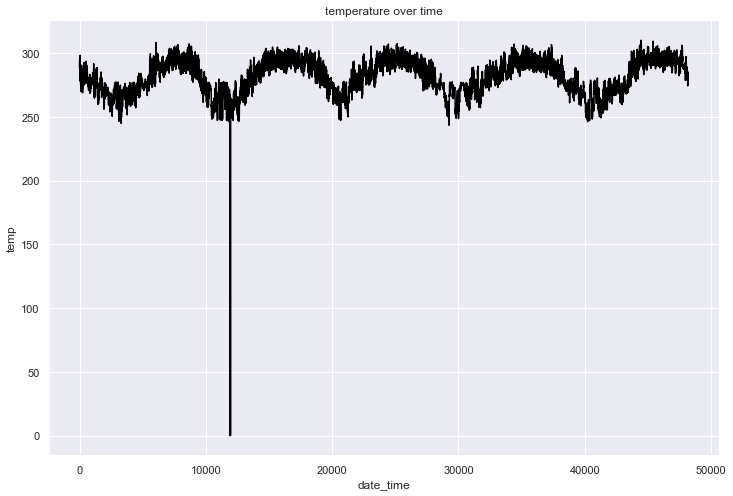

time: 219 ms (started: 2023-04-05 17:52:35 -06:00)


In [250]:
# Plotting temperature over time for entire dataset
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df['temp'], color = "black")

ax.set_xlabel('date_time');
ax.set_ylabel('temp')
ax.set_title('temperature over time');

It appears that the temperature follows an expected seasonal pattern except for a smattering of values that are listed as zero. Let's explore where those values are.

In [251]:
# Viewing zero values for the 'temp' column
df[df['temp'] == 0]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
11898,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 03:00:00,361
11899,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 04:00:00,734
11900,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 05:00:00,2557
11901,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 06:00:00,5150
11946,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 03:00:00,291
11947,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 04:00:00,284
11948,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 05:00:00,434
11949,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 06:00:00,739
11950,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:00,962
11951,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:00,1670


time: 15 ms (started: 2023-04-05 17:52:35 -06:00)


There are two days in early 2014 that have a few hours with the temperature listed at zero. We know that the 'temp' column is listed in units of Kelvin; zero degrees Kelvin is the lowest limit of the thermodynamic temperature scale where atoms/particles stop moving so it is safe to assume this data is not accurate.

To fix this, we'll take a look at the recorded temperatures immediately before and after the inaccurate temperature data and fill them in with the average value.

In [252]:
# Viewing temperature values immediately before and after the inaccurate data
df['temp'].loc[11897:11902], df['temp'].loc[11945:11952]

(11897    255.93
 11898      0.00
 11899      0.00
 11900      0.00
 11901      0.00
 11902    255.93
 Name: temp, dtype: float64,
 11945    255.37
 11946      0.00
 11947      0.00
 11948      0.00
 11949      0.00
 11950      0.00
 11951      0.00
 11952    255.62
 Name: temp, dtype: float64)

time: 0 ns (started: 2023-04-05 17:52:35 -06:00)


In [253]:
# Setting inaccurate values to be equal to the average of the values immediately before and after
df['temp'].loc[11898:11901] = (df['temp'].loc[11897] + df['temp'].loc[11902]) / 2
df['temp'].loc[11946:11951] = (df['temp'].loc[11945] + df['temp'].loc[11952]) / 2

time: 0 ns (started: 2023-04-05 17:52:35 -06:00)


C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


11897    255.93
11898    255.93
11899    255.93
11900    255.93
11901    255.93
11902    255.93
Name: temp, dtype: float64 11944    255.480
11945    255.370
11946    255.495
11947    255.495
11948    255.495
11949    255.495
11950    255.495
11951    255.495
11952    255.620
Name: temp, dtype: float64


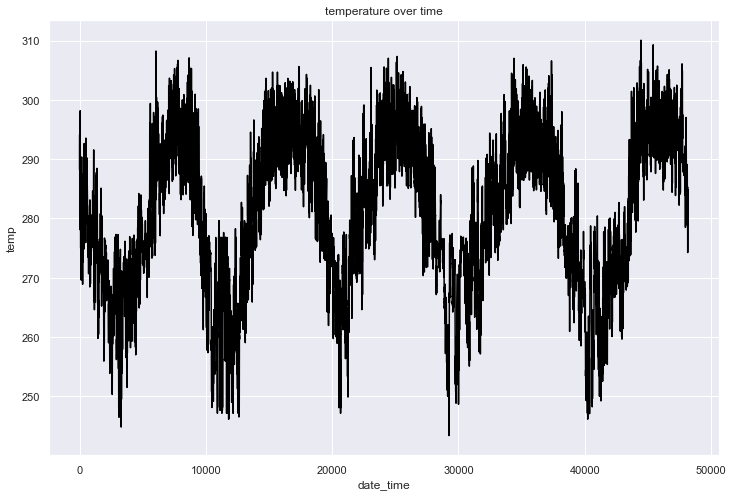

time: 266 ms (started: 2023-04-05 17:52:35 -06:00)


In [254]:
# Checking results
print(df['temp'].loc[11897:11902], df['temp'].loc[11944:11952])

# Plotting again for visual inspection
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df['temp'], color = "black", label='Temp')

ax.set_xlabel('date_time')
ax.set_ylabel('temp')
ax.set_title('temperature over time');

The plot looks better now that we've filled in the zero values for the temperature data. It follows the expected seasonal trend of decreasing temperatures as winter approaches and increasing temperatures as summer approaches. Next let's visually inspect the other numeric variables in the dataset: *rain_1h*, *snow_1h*, *clouds_all*, and *traffic_volume*.

Text(0.5, 1.0, 'traffic_volume')

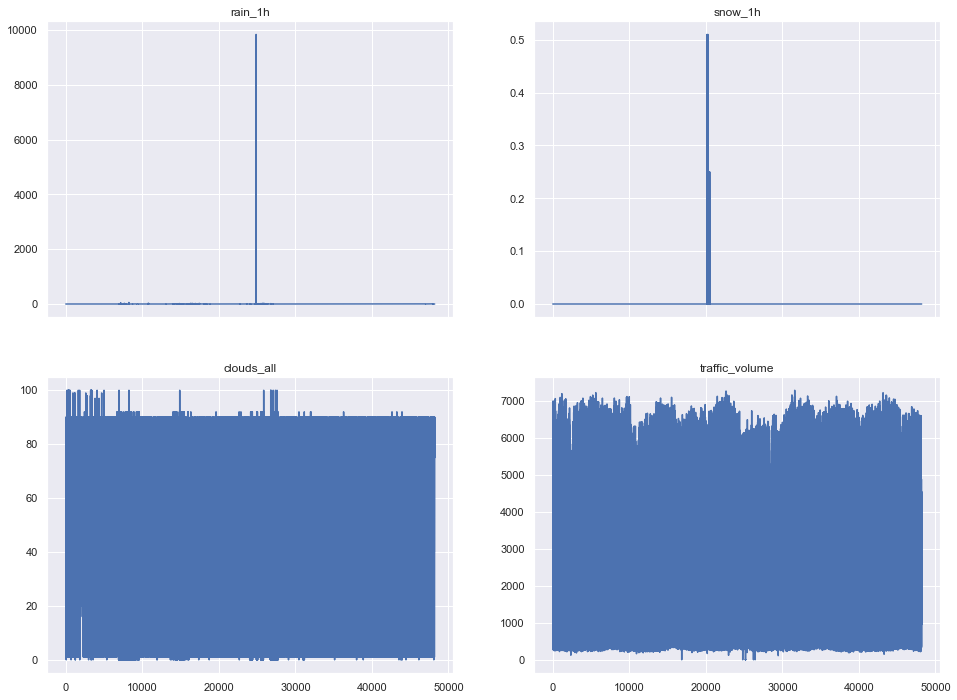

time: 750 ms (started: 2023-04-05 17:52:36 -06:00)


In [255]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,12))
axes[0, 0].plot(df['rain_1h']); axes[0, 0].set_title('rain_1h')
axes[0, 1].plot(df['snow_1h']); axes[0, 1].set_title('snow_1h')
axes[1, 0].plot(df['clouds_all']); axes[1, 0].set_title('clouds_all')
axes[1, 1].plot(df['traffic_volume']); axes[1, 1].set_title('traffic_volume')

*clouds_all* and *traffic_volume* appear to have normal values across the dataset but there are some odd looking spikes in the data for *rain_1h* and *snow_1h*. Both of these are measured in millimeters. It's unlikely that a singular day or hour produced almost 10,000 mm of rain and the snow values are suspiciously low for a state as far North as Minnesota.

To fix this, I obtained a dataset compiled by the [National Oceanic and Atmospheric Administration (NOAA)](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00014922/detail). The dataset provides daily weather data gathered by a weather station at the Minneapolis St. Paul International Airport and can be used to cross-reference the UCI dataset.

In [256]:
# Top 10 hourly rainfall values
df.sort_values(by='rain_1h', ascending=False).head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
24872,None,302.11,9831.30,0.0,75,Rain,very heavy rain,2016-07-11 17:00:00,5535
8247,None,289.10,55.63,0.0,68,Rain,very heavy rain,2013-08-07 02:00:00,315
7179,None,295.82,44.45,0.0,76,Rain,very heavy rain,2013-06-24 11:00:00,4802
25779,None,297.71,31.75,0.0,0,Rain,very heavy rain,2016-08-16 17:00:00,4913
10807,None,264.50,28.70,0.0,64,Snow,light snow,2013-12-19 23:00:00,1190


time: 31 ms (started: 2023-04-05 17:52:36 -06:00)


In [257]:
# Totalling snowfall values across entire dataset
df['snow_1h'].sum()

10.72

time: 0 ns (started: 2023-04-05 17:52:37 -06:00)


It's highly unlikely that 9,831 mm (approximately 32 feet!) of rain fell in one hour. It's also extremely unlikely that the total amount of snowfall listed across the entire dataset is 10.72 mm (0.42 inches). To fix this, we'll make some changes to the *date_time* column and the overall dataframe until we have a daily time series with complete and sensible values.

In [258]:
# Converting date_time column from object to datetime
df['date_time'] = pd.to_datetime(df['date_time'], infer_datetime_format=True)

# Extracting various values from date_time column
df['date'] = df['date_time'].dt.date
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['weekday'] = df['date_time'].dt.day_name()
df['hour'] = df['date_time'].dt.hour

# Converting newly created date column from object to datetime
df['date'] = pd.to_datetime(df['date'])

time: 94 ms (started: 2023-04-05 17:52:37 -06:00)


In [259]:
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,date,year,month,day,weekday,hour
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2012-10-02,2012,10,2,Tuesday,9
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,2012-10-02,2012,10,2,Tuesday,10
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,2012-10-02,2012,10,2,Tuesday,11
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2012-10-02,2012,10,2,Tuesday,12
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2012-10-02,2012,10,2,Tuesday,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543,2018-09-30,2018,9,30,Sunday,19
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781,2018-09-30,2018,9,30,Sunday,20
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159,2018-09-30,2018,9,30,Sunday,21
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450,2018-09-30,2018,9,30,Sunday,22


time: 31 ms (started: 2023-04-05 17:52:37 -06:00)


In [262]:
df_daily = df[['date', 'traffic_volume']]

time: 0 ns (started: 2023-04-05 17:54:29 -06:00)


In [263]:
df_daily

,date,traffic_volume
0,2012-10-02,5545
1,2012-10-02,4516
2,2012-10-02,4767
3,2012-10-02,5026
4,2012-10-02,4918
...,...,...
48199,2018-09-30,3543
48200,2018-09-30,2781
48201,2018-09-30,2159
48202,2018-09-30,1450


time: 16 ms (started: 2023-04-05 17:54:31 -06:00)


In [266]:
df_daily = df_daily.groupby(pd.Grouper(key='date', axis=0, freq='D')).sum()

time: 0 ns (started: 2023-04-05 17:55:19 -06:00)


In [281]:
df_daily.isna().sum()

traffic_volume    0
dtype: int64

time: 0 ns (started: 2023-04-05 18:13:08 -06:00)


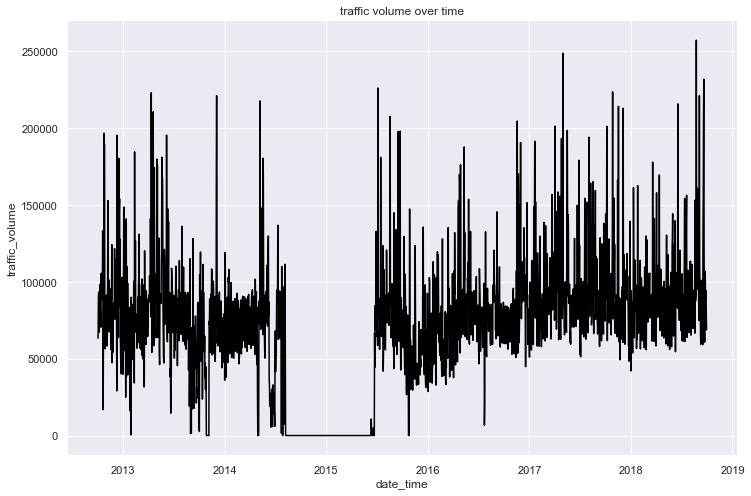

time: 250 ms (started: 2023-04-05 18:13:25 -06:00)


In [282]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df_daily, color = "black")

ax.set_xlabel('date_time')
ax.set_ylabel('traffic_volume')
ax.set_title('traffic volume over time');

## Baseline Model

In [274]:
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error

# Create lagged dataset
values = DataFrame(df_daily.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

       t-1    t+1
0      NaN  63289
1  63289.0  66345
2  66345.0  89939
3  89939.0  93336
4  93336.0  74910
time: 15 ms (started: 2023-04-05 18:08:03 -06:00)


In [275]:
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.75)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

time: 0 ns (started: 2023-04-05 18:09:33 -06:00)


In [276]:
# persistence model
def model_persistence(x):
 return x

time: 0 ns (started: 2023-04-05 18:09:46 -06:00)


In [277]:
# walk-forward validation
predictions = list()
for x in test_X:
 yhat = model_persistence(x)
 predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 1422240667.569
time: 0 ns (started: 2023-04-05 18:10:07 -06:00)


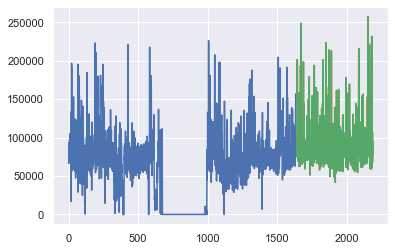

time: 157 ms (started: 2023-04-05 18:11:09 -06:00)


In [279]:
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

In [215]:
df.set_index('date', inplace=True)

time: 0 ns (started: 2023-04-05 17:45:50 -06:00)


In [217]:
# Renaming columns to show units of measurement
df = df.rename(columns={'rain_1h':'rain_mm',
                        'snow_1h':'snow_mm',
                        'clouds_all':'pct_cloud_cover'})

# Converting temp column to Fahrenheit values
df['temp'] = (df['temp'] - 273.15) * 9/5 + 32

time: 16 ms (started: 2023-04-05 17:46:14 -06:00)


In [218]:
df

,holiday,temp,rain_mm,snow_mm,pct_cloud_cover,weather_main,weather_description,date_time,traffic_volume,year,month,day,weekday,hour
date,,,,,,,,,,,,,,
2012-10-02,None,59.234,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2012,10,2,Tuesday,9
2012-10-02,None,61.178,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,2012,10,2,Tuesday,10
2012-10-02,None,61.574,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,2012,10,2,Tuesday,11
2012-10-02,None,62.564,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2012,10,2,Tuesday,12
2012-10-02,None,64.382,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2012,10,2,Tuesday,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30,None,50.540,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543,2018,9,30,Sunday,19
2018-09-30,None,49.298,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781,2018,9,30,Sunday,20
2018-09-30,None,49.244,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159,2018,9,30,Sunday,21


time: 31 ms (started: 2023-04-05 17:46:16 -06:00)


In [220]:
df_daily = df.resample('D').agg({'rain_mm' : 'sum',
                                 'snow_mm' : 'sum',
                                 'pct_cloud_cover' : 'mean',
                                 'temp' : 'mean',
                                 'traffic_volume' : 'sum'})

time: 16 ms (started: 2023-04-05 17:46:41 -06:00)


In [221]:
df_daily

,rain_mm,snow_mm,pct_cloud_cover,temp,traffic_volume
date,,,,,
2012-10-02,0.00,0.0,29.133333,63.056000,4219.266667
2012-10-03,0.00,0.0,3.850000,55.874300,3317.250000
2012-10-04,0.00,0.0,16.708333,61.173500,3747.458333
2012-10-05,0.00,0.0,75.000000,48.070727,4242.545455
2012-10-06,0.00,0.0,61.652174,40.272957,3256.956522
...,...,...,...,...,...
2018-09-26,0.25,0.0,39.833333,51.522500,3692.791667
2018-09-27,0.50,0.0,61.200000,55.613120,3777.360000
2018-09-28,0.00,0.0,26.250000,47.189000,3854.916667


time: 0 ns (started: 2023-04-05 17:46:45 -06:00)


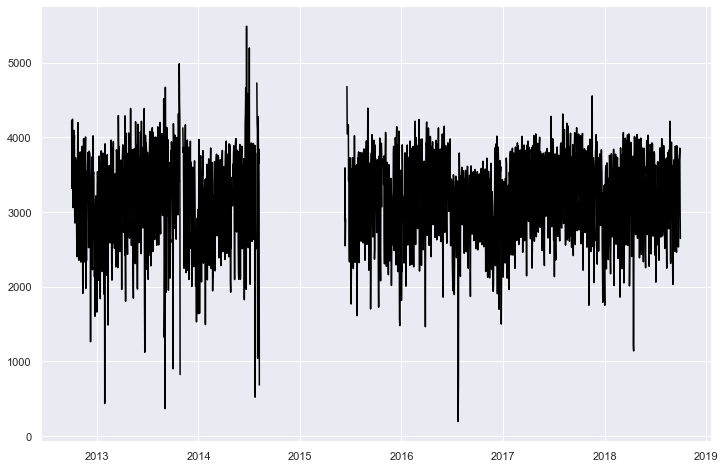

time: 235 ms (started: 2023-04-05 17:48:00 -06:00)


In [223]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df_daily['traffic_volume'], color = "black");

In [224]:
df_daily.isna().sum()

rain_mm              0
snow_mm              0
pct_cloud_cover    330
temp               330
traffic_volume     330
dtype: int64

time: 0 ns (started: 2023-04-05 17:48:43 -06:00)


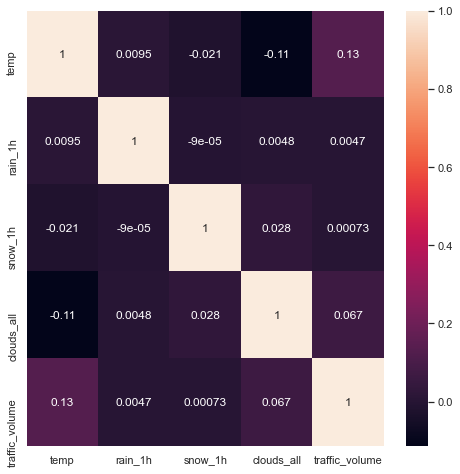

time: 328 ms (started: 2023-04-05 14:20:44 -06:00)


In [10]:
# Plotting correlation heatmap

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True);

In [11]:
# Renaming columns to show units of measurement
df = df.rename(columns={'temp':'temp_k',
                        'rain_1h':'rain_mm',
                        'snow_1h':'snow_mm',
                        'clouds_all':'pct_cloud_cover'})

# Creating column with Fahrenheit values
df['temp_f'] = (df['temp_k'] - 273.15) * 9/5 + 32

time: 16 ms (started: 2023-04-05 14:20:45 -06:00)


In [12]:
df['date_time'] = pd.to_datetime(df['date_time'], infer_datetime_format=True)
df.set_index('date_time', inplace=True)

time: 47 ms (started: 2023-04-05 14:20:45 -06:00)


In [13]:
df

,holiday,temp_k,rain_mm,snow_mm,pct_cloud_cover,weather_main,weather_description,traffic_volume,temp_f
date_time,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,59.234
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,61.178
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,61.574
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,62.564
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,64.382
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,None,283.45,0.0,0.0,75,Clouds,broken clouds,3543,50.540
2018-09-30 20:00:00,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2781,49.298
2018-09-30 21:00:00,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159,49.244


time: 31 ms (started: 2023-04-05 14:20:45 -06:00)


In [14]:
df_daily = df.resample('D').agg({'rain_mm' : 'sum',
                                 'snow_mm' : 'sum',
                                 'pct_cloud_cover' : 'mean',
                                 'temp_f' : 'mean',
                                 'traffic_volume' : 'mean'})

time: 62 ms (started: 2023-04-05 14:20:45 -06:00)


In [15]:
df_daily

,rain_mm,snow_mm,pct_cloud_cover,temp_f,traffic_volume
date_time,,,,,
2012-10-02,0.00,0.0,29.133333,63.056000,4219.266667
2012-10-03,0.00,0.0,3.850000,55.874300,3317.250000
2012-10-04,0.00,0.0,16.708333,61.173500,3747.458333
2012-10-05,0.00,0.0,75.000000,48.070727,4242.545455
2012-10-06,0.00,0.0,61.652174,40.272957,3256.956522
...,...,...,...,...,...
2018-09-26,0.25,0.0,39.833333,51.522500,3692.791667
2018-09-27,0.50,0.0,61.200000,55.613120,3777.360000
2018-09-28,0.00,0.0,26.250000,47.189000,3854.916667


time: 16 ms (started: 2023-04-05 14:20:45 -06:00)


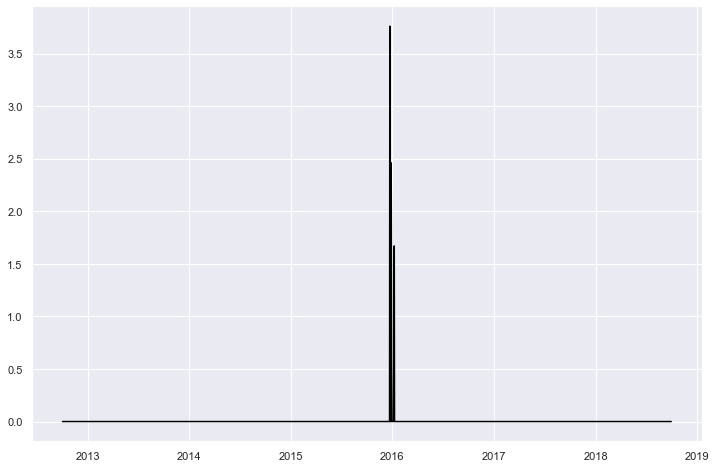

time: 250 ms (started: 2023-04-05 14:20:45 -06:00)


In [16]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df_daily['snow_mm'], color = "black", label='Temp');

In [17]:
df_daily.isna().sum()

rain_mm              0
snow_mm              0
pct_cloud_cover    330
temp_f             330
traffic_volume     330
dtype: int64

time: 16 ms (started: 2023-04-05 14:20:45 -06:00)


In [18]:
df_daily['temp_f'] = df_daily['temp_f'].interpolate()

time: 15 ms (started: 2023-04-05 14:20:45 -06:00)


In [19]:
df_daily.isna().sum()

rain_mm              0
snow_mm              0
pct_cloud_cover    330
temp_f               0
traffic_volume     330
dtype: int64

time: 16 ms (started: 2023-04-05 14:20:45 -06:00)


In [20]:
df_daily['2014-10-01':'2015-01-01']

,rain_mm,snow_mm,pct_cloud_cover,temp_f,traffic_volume
date_time,,,,,
2014-10-01,0.0,0.0,NaN,65.889773,NaN
2014-10-02,0.0,0.0,NaN,65.858528,NaN
2014-10-03,0.0,0.0,NaN,65.827283,NaN
2014-10-04,0.0,0.0,NaN,65.796038,NaN
2014-10-05,0.0,0.0,NaN,65.764793,NaN
...,...,...,...,...,...
2014-12-28,0.0,0.0,NaN,63.140217,NaN
2014-12-29,0.0,0.0,NaN,63.108972,NaN
2014-12-30,0.0,0.0,NaN,63.077727,NaN


time: 16 ms (started: 2023-04-05 14:20:45 -06:00)
